# Value-at-Risk versus Expected Shortfall
*Content inspired from investopedia*

**Value-at-Risk** (shortened as VaR) and **Expected Shortfall** (shortened as ES) are measures of risk incurred by a financial portfolio or instrument (e.g. stock).

## Value-at-Risk
Given a confidence level ⍺ (e.g. 5%), the VaR (100-⍺)% (e.g. VaR 95%) of a financial portfolio or instrument is the **upper limit** (or cut-off point) of their expected returns in the ⍺% percentile of their return distribution over a specific timeframe (a 1-year period is often standard).

## Expected Shortfall
Also called *conditional VaR* (CVaR), ES represents the expected loss **when it is greater than** the calculated VaR value (a cutt-off point), given the confidence level ⍺. 

## Extracting Stock Data

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.stats import norm

In [2]:
pandas_type = "pandas.core.frame.DataFrame"

In [3]:
def download_stock_data(ticker: str) -> (str, pandas_type):
    """
    Downloads and reshapes stock data based on the yfinance library.
    """
    daily_stock_data = yf.download(ticker)
    column = [col for col in daily_stock_data.columns if col != "Adj Close"]
    stock = daily_stock_data.drop(columns = column)
    stock = stock[-260:] #260 is the expected number of business days in a year
    return ticker, stock

In [4]:
def calculate_stock_return(ticker: str, stock: pandas_type) -> (str, pandas_type):
    """
    Calculates daily returns over the available period.
    Plots stock returns.
    """
    stock = stock[1:].values / stock[:-1] - 1
    stock.dropna()
    
    fig = plt.figure(figsize=(20,10))
    
    ax = fig.add_subplot(111)
    ax.plot(stock, linewidth = 2)
    
    ax.set_xlabel('Time', fontsize=18)
    ax.set_ylabel('% Return', fontsize=18)
    ax.set_title("Return Time Series", size=25, weight = "bold")
    
    ax.grid(linestyle='-', linewidth='0.5', color='red')
    
    return ticker, stock

In [5]:
def standard_deviation(stock: pandas_type) -> pandas_type:
    """
    Calculates standard deviation of stock over the available period.
    """
    mean = stock.mean()
    stock = (stock - mean)**2
    return math.sqrt(stock.mean())

In [6]:
def show_distribution(ticker: str, stock: pandas_type) -> None:
    """
    Plots the distribution of returns of the stock over the available period.
    """
    normal_dist = np.random.normal(0, standard_deviation(stock), len(stock))
    fig = plt.figure(figsize=(20,10))
    
    fig = plt.hist(normal_dist, bins=30, density=True, alpha=0.5,
                   histtype='stepfilled', color='red', edgecolor = 'gray', 
                   label = "Normal Distribution")
    
    fig = plt.hist(stock.transpose(), bins=30, density=True, alpha=0.5,
                   histtype='stepfilled', color='steelblue', edgecolor = 'gray', 
                   label = ticker + " Return")
    
    fig = plt.xlabel('% Return', fontsize=18)
    fig = plt.ylabel('Nb of Times', fontsize=18)
    fig = plt.title('Return Distribution', fontsize=25, weight = "bold")
    
    fig = plt.legend(fontsize=18)
    
    return None

## Calculating the VaR of Goldman Sachs [GS]

In [7]:
def value_at_risk(alpha: float, ticker: str, stock: pandas_type, quantile: bool = True) -> float:
    """
    Calculates value-at-risk over the past year.
    """
    ticker_value = yf.Ticker(ticker)
    value = ticker_value.info["bid"]
    
    if quantile == True:
        percentage = stock.quantile(alpha)
        value *= percentage[0]
        
        value = np.around(value, 2)
        percentage = round(percentage[0] * 100, 2)
        
        print(f"Based on quantile:\n The value-at-risk of one stock of company " + 
              f"{ticker} is {value} in {ticker_value.info['currency']} " +
              f"or {percentage}% of current value ${ticker_value.info['bid']} (as at today).")
        return stock.quantile(alpha)
    
    else:
        mean_returns = stock.mean()
        st_dev_returns = standard_deviation(stock)
        alpha = norm.ppf(1 - alpha, mean_returns, st_dev_returns)
        value -= value * (alpha + 1)
       
        value = np.around(value, 2)
        alpha = np.around(alpha * 100, 2)
        
        print(f"Based on normal distribution:\n The value-at-risk of one stock of company " + 
              f"{ticker} is {value[0]} in {ticker_value.info['currency']} " +
              f"or -{alpha[0]}% of current value ${ticker_value.info['bid']} (as at today).")
        return value

[*********************100%***********************]  1 of 1 downloaded


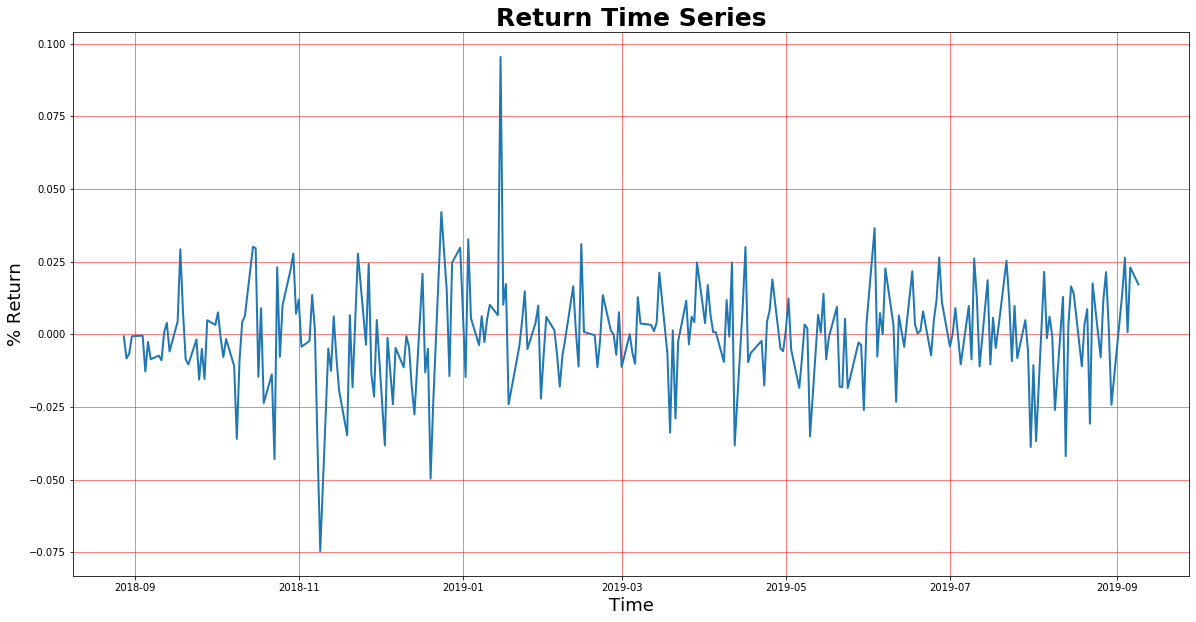

In [8]:
stock = download_stock_data("GS")
stock = calculate_stock_return(stock[0],stock[1])

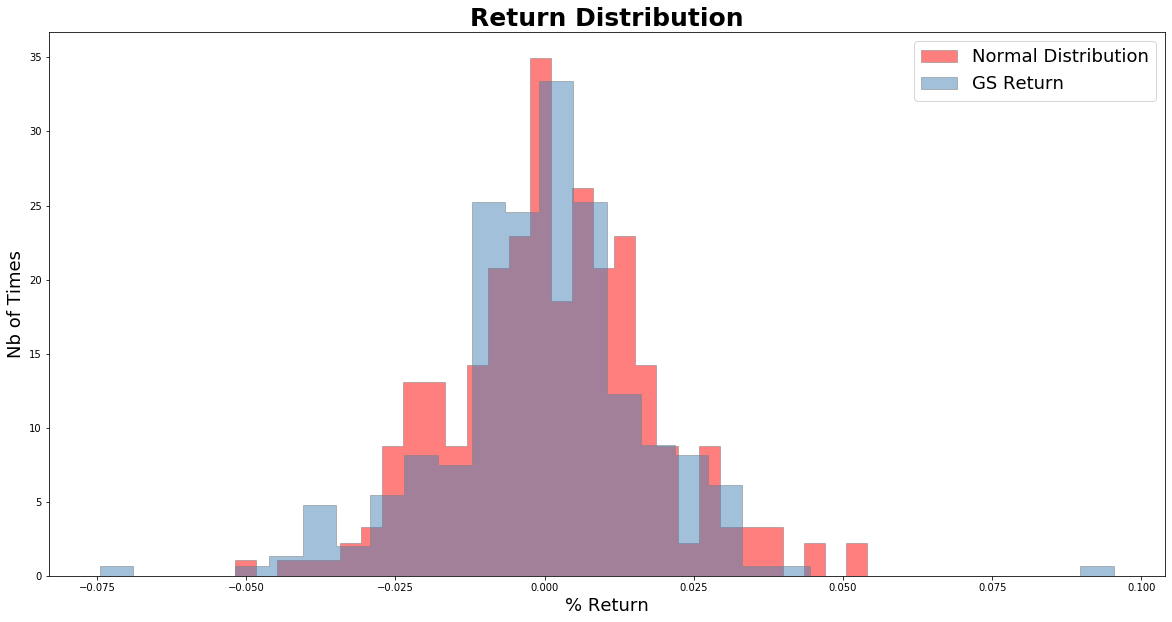

In [9]:
show_distribution(stock[0],stock[1])

In [10]:
alpha = 0.05
VaR95_actual_percentile = value_at_risk(alpha, stock[0], stock[1], True)
VaR95_actual_percentile = value_at_risk(alpha, stock[0], stock[1], False)

Based on quantile:
 The value-at-risk of one stock of company GS is -6.68 in USD or -3.1% of current value $215.27 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company GS is -6.1 in USD or -2.83% of current value $215.27 (as at today).


In [11]:
# verification
var_95 = np.percentile(stock[1], 5)
print(round(var_95*100,2))

-3.1


In [12]:
alpha = 0.01
VaR99_actual_percentile = value_at_risk(alpha, stock[0], stock[1], True)
VaR99_actual_percentile = value_at_risk(alpha, stock[0], stock[1], False)

Based on quantile:
 The value-at-risk of one stock of company GS is -9.11 in USD or -4.23% of current value $215.27 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company GS is -8.65 in USD or -4.02% of current value $215.27 (as at today).


In [13]:
# verification
var_99 = np.percentile(stock[1], 1)
print(round(var_99*100,2))

-4.23


### Conclusion of calculation of VaR
GS returns do not seem to fit follow a normal distribution.

## Calculating the ES of Goldman Sachs [GS]

In [14]:
def expected_shortfall(alpha: float, ticker: str, stock: pandas_type, quantile: bool = True) -> float:
    """
    Calculates expected shortfall over the past year.
    """
    ticker_value = yf.Ticker(ticker)
    value = ticker_value.info["bid"]
    percentage = value_at_risk(alpha, ticker, stock, quantile)
    
    if quantile == True:        
        stock = stock[stock <= percentage]
        stock_mean = stock.mean()
        value *= stock_mean
        print(f"Based on quantile:\n The expected shortfall of one stock of company " + 
              f"{ticker} is {round(value[0],2)} in {ticker_value.info['currency']} " +
              f"or {round(stock_mean[0]*100,2)}% of current value ${ticker_value.info['bid']} (as at today).")
        return stock_mean
    
    else:
        stock_mean = stock.mean()
        st_dev_returns = standard_deviation(stock)
        alpha = norm.ppf(1 - alpha, stock_mean, st_dev_returns)
        stock = stock[stock <= -alpha]
        alpha = (value * stock.mean())/ value
        value *= stock.mean()
       
        value = np.around(value, 2)
        alpha = np.around(alpha * 100, 2)
        
        print(f"Based on normal distribution:\n The expected shortfall of one stock of company " + 
              f"{ticker} is {value[0]} in {ticker_value.info['currency']} " +
              f"or {alpha[0]}% of current value ${ticker_value.info['bid']} (as at today).")
        return value

In [15]:
alpha = 0.05
CVaR95_actual_percentile = expected_shortfall(alpha, stock[0], stock[1], True)
CVaR95_actual_percentile = expected_shortfall(alpha, stock[0], stock[1], False)

Based on quantile:
 The value-at-risk of one stock of company GS is -6.68 in USD or -3.1% of current value $215.27 (as at today).
Based on quantile:
 The expected shortfall of one stock of company GS is -8.93 in USD or -4.15% of current value $215.27 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company GS is -6.1 in USD or -2.83% of current value $215.27 (as at today).
Based on normal distribution:
 The expected shortfall of one stock of company GS is -8.59 in USD or -3.99% of current value $215.27 (as at today).


In [16]:
#verification
stock_return = stock[1]
var_95 = np.percentile(stock_return, 5)
cvar_95 = stock_return[stock_return <= var_95].mean()
print(round(cvar_95[0]*100, 2))

-4.15


In [17]:
alpha = 0.01
CVaR99_actual_percentile = expected_shortfall(alpha, stock[0], stock[1], True)
CVaR99_actual_percentile = expected_shortfall(alpha, stock[0], stock[1], False)

Based on quantile:
 The value-at-risk of one stock of company GS is -9.11 in USD or -4.23% of current value $215.27 (as at today).
Based on quantile:
 The expected shortfall of one stock of company GS is -11.99 in USD or -5.57% of current value $215.27 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company GS is -8.65 in USD or -4.02% of current value $215.27 (as at today).
Based on normal distribution:
 The expected shortfall of one stock of company GS is -11.25 in USD or -5.23% of current value $215.27 (as at today).


In [18]:
#verification
stock_return = stock[1]
var_99 = np.percentile(stock_return, 1)
cvar_99 = stock_return[stock_return <= var_99].mean()
print(round(cvar_99[0]*100, 2))

-5.57


## Advantage of ES over VaR
ES is a risk measure that quantifies the tail risk a financial portfolio or instrument. ES is calculated by taking a weighted average of the losses in the tail of the distribution of a financial portfolio or instrument's possible returns.

##### Tail Risk
Tail risk arises the returns of a financial portfolio or instrument diverge from the typical idea that market returns follow a normal distribution (i.e. assumption of traditional portfolio strategies). That is the possibility that an investment will move more than three standard deviations from the mean is greater than what is shown by a normal distribution. Tail risks include events that have a small probability of occurring, and occur at both ends of a normal distribution curve. This is the concept of "fat tails" or skewness.